# Classification of Handwritten Digits Using Tangents

## Installs & Upgrades (remove comments if you deem it necessary)

In [16]:
#!pip install numpy --upgrade
#!pip install pandas --upgrade
#!pip install matplotlib --upgrade
#!pip install scikit-learn --upgrade

## Import Files

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## Read CSV

In [18]:
training_images = 'Data/azip.csv'
digits = 'Data/dzip.csv'
test_images = 'Data/testzip.csv'
test_digits = 'Data/dtest.csv'

## Load the Data

First we instantly convert each column to a matrix. The result will be a 3D-matrix and for each data row we will have a 16x16 matrix. Then, we convert the result to a 20x20 image by padding "-1" since it makes all of the pixels white. Finally, we reshape the result and get a 2D matrix once again which will have 400 rows.

Also, the exercise asks to compute the tangent distance column-wise, so we add "order = 'F'". This means "Fortran style" which is known as column-major order, the elements of the array are stored in a contiguous block of memory, with the first index changing fastest. It means that the elements of the array belonging to the same column are stored adjacent to each other. This is not particularly effective, but its what the exercise asks for, so the whole implementation is based on this. Moreover, due to the column-wise philosophy, we are forced to reshape many times with an unconventional way for Python, as we have to do +20 steps in memory constantly, which also costs to the total effectiveness of the algorithm.

In [19]:
x_train = np.array(pd.read_csv(training_images, header = None)).T.reshape(-1, 16, 16)
x_train = np.pad(x_train, ((0,0), (2, 2), (2, 2)), constant_values=-1).reshape(x_train.shape[0], 400, order = 'F').T

y_train = np.array(pd.read_csv(digits, header = None))

x_test = np.array(pd.read_csv(test_images, header = None)).T.reshape(-1, 16, 16)
x_test = np.pad(x_test, ((0,0), (2, 2), (2, 2)), constant_values=-1).reshape(x_test.shape[0], 400, order = 'F').T

y_test = np.array(pd.read_csv(test_digits, header = None))

## Calculate the Derivatives

This part computes the x-derivatives and y-derivatives of each digit using finite difference approximation. It first converts the data back to a 20x20 shape (by using order = 'F' like we explained above) and then it adds one column/row containing 0's. This happens because the derivative calculation for a column/row with n elements results in n-1 elements. Then it returns the result back to a vector form using flatten().

In [20]:
def x_der(p):
    p = p.reshape(20,20,order="F")
    dx = np.diff(p, axis=1)
    dx = np.hstack((dx, np.zeros((20, 1))))
    return dx.flatten(order = 'F')

def y_der(p):
    p = p.reshape(20,20,order="F")
    dy = np.diff(p, axis = 0)
    dy = np.vstack((dy, np.zeros(20,)))
    return dy.flatten(order = 'F')

Additionally, we create a list containing tuples where each tuple will contain the dx, dy of each training data row.

In [21]:
tuples = []

for i in range(x_train.shape[1]):
    dx = x_der(x_train[:,i])
    dy = y_der(x_train[:,i])
    tuples.append((dx, dy))

## Visualization of a Transformation

Having calculated the dx, dy of the data we already have 2 of the 7 transformations. Below we add an example of the visual result of dx. For the depictions we use *my_map1* which describes what "ima2.m" does, a file given by the exercise with Matlab format. The first image is the original one and the second one is the result after the transformation using dx.

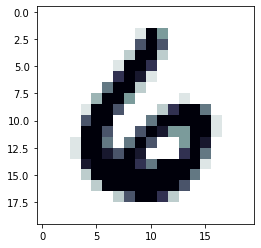

In [22]:
mymap1 = [1.0000, 1.0000, 1.0000, 0.8715, 0.9028, 0.9028, 0.7431, 0.8056, 0.8056, 0.6146, 0.7083, 0.7083, 0.4861, 0.6111, 0.6111, 0.3889, 0.4722, 0.5139,0.2917, 0.3333, 0.4167, 0.1944, 0.1944, 0.3194, 0.0972, 0.0972, 0.1806, 0, 0, 0.0417]
mymap1 = np.array(mymap1).reshape(-1,3)
cmap= plt.cm.colors.ListedColormap(mymap1)

plt.imshow(x_train[:,0].reshape(20, 20, order = 'F'), cmap=cmap)

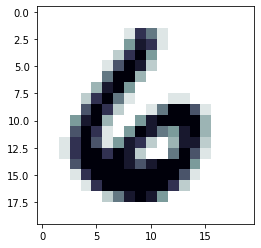

In [23]:
shifted_image = x_train[:,0].reshape(20, 20, order="F")+tuples[0][0].reshape(20, 20, order="F")*0.7

plt.imshow(shifted_image, cmap=cmap)

*If you look closely you can see that the number has been shifted to the left*

## Set the coordinates of each point

For the 2 first transformations, dx and dy were enough. To apply rotation and the rest of the transformations we need the coordinates of each point and using numpy's meshgrid we achieve that effectively. This will be used by data rows of both train and test matrices.

In [24]:
x, y = np.meshgrid(range(20), range(20), indexing='xy')
x = x.flatten(order = 'F')
y = y.flatten(order = 'F')

## Define all of the transformations

Below we define a function that takes the coordinates of a data row and its dx, dy as an input, and implements all of the 7 transformations. It will have 7 columns, one for each transformation (vertically stacked) and the final shape will be 400x7, where 400 is the length of the initial vector. The 7 transformations mentioned shortly:
* x-Translation -> The pattern is translated by αx in the x-direction.
    * Its formula is: **dx**
* y-Translation -> The pattern is translated by αy in the y-direction.
    * Its formula is: **dy**
* Rotation -> A rotation of the pattern by an angle αr.
    * Its formula is: **y \* dx - x \* dy**
* Scaling -> A scaling of the pattern.
    * Its formula is: **x \* dx + y \* dy**
* Parallel Hyperbolic Transformation -> We stretch the pattern parallel to the axis.
    * Its formula is: **x \* dx - y \* dy**
* Diagonal Hyperbolic Transformation -> We stretch the pattern along diagonals.
    * Its formula is: **y \* dx + x \* dy**
* Thickening -> The pattern can be made thinner or thicker
    * Its formula is: **dx \*\* 2 + dy \*\* 2**

In [25]:
def transformations(x, dx, y, dy):
    matrix = np.vstack((dx, dy, y*dx - x*dy, x*dx + y*dy, x*dx - y*dy, y*dx + x*dy, dx**2 + dy**2)).T
    return matrix

## Training

Next, we complete the training which is quite simple considering the fact that we have computed all of the transformations above. For each data row, we extract its coordinates and dx, dy computed before and we pass them as an argument to the function we defined above. The result is the matrix *Tp* as defined by the book. We do this for each data row and we store them in "tp_train".

In [26]:
tp_train = np.zeros((x_train.shape[1], 400, 7))
for i in range(x_train.shape[1]):
    dx = tuples[i][0]
    dy = tuples[i][1]
    tp_train_temp = transformations(x, dx, y, dy)
    tp_train[i] = tp_train_temp

## Predictions

At last, we can make our predictions. We get each test data row and calculate its *Te* matrix as defined by the book. This must be compared with all of the matrices in "tp_train" and this is mainly the reason why this method is not effective (and therefore not used by many). For each comparison we calculate the least squares using numpy's built in function, where "A" is the concatenated matrix [-Tp Te]. Simultaneously, b is computed by subtracting the original (correct) vectors, the first the being data row being classified, and the latter the corresponding training row that it is compared in this iteration. Subsequently, we store the residuals and the predicted label and we keep only the minimum residual along with its predicted label. This whole process is repeated for every test row. The final result is an array "predicted_labels" which contains all of our predictions.

*This takes approximately 7.5 - 8 minutes to run.*

In [27]:
predicted_labels = np.zeros(y_test.shape[1])
for i in range(x_test.shape[1]):
    dx = x_der(x_test[:,i])
    dy = y_der(x_test[:,i])
    temp = []
    tp_test = transformations(x, dx, y, dy)
    for j in range(x_train.shape[1]):
        T = np.hstack((-tp_train[j], tp_test))
        b = x_train[:,j] - x_test[:,i]
        _, residuals, _, _ = np.linalg.lstsq(T, b, rcond=None)
        temp.append((residuals[0], y_train[0][j]))
        
    res, c = min(temp)
    predicted_labels[i] = int(c)

## Compute the Algorithm's Accuracy

In [28]:
true_labels = y_test[0]
accuracy = np.sum(predicted_labels == true_labels) / len(true_labels)

print("Accuracy: {:.2f} ".format(accuracy*100),"%")

Accuracy: 94.27  %


## Compute the Algorithm's F1

As we know, accuracy is not always trustworthy, especially in multi-class problems, so we will compute F1-score as well.

In [29]:
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       359
           1       0.92      0.98      0.95       264
           2       0.94      0.89      0.92       198
           3       0.94      0.93      0.93       166
           4       0.94      0.92      0.93       200
           5       0.94      0.86      0.90       160
           6       0.97      0.96      0.96       170
           7       0.94      0.94      0.94       147
           8       0.96      0.92      0.94       166
           9       0.94      0.98      0.96       177

    accuracy                           0.94      2007
   macro avg       0.94      0.94      0.94      2007
weighted avg       0.94      0.94      0.94      2007



We can see that the resulting accuracy is great! It is a bit better than the accuracy we got using SVD (it was 94.17%) but considering how slower this method is, it is definitely not recommended. F1-Score is great as well, (94% in total) which ensures us that the algorithm is working well and that the classification is performed as it should be. It should be mentioned that the book provides an alternate solution implementing QR decomposition to find the squared norm of Q_2^T@b which skips the whole process we just completed, but computing full QR thousands of times inside the for loops will definitely be slow as well (and probably much slower). In general, these methods need many and spot on alterations to work efficiently, and this project is just an introduction to these methods.

*This implementation is based on the book "Matrix Methods in Data Mining and Pattern Recognition"*